## Some simple tests

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, fftfreq
import matplotlib.pyplot as plt
import time
import scipy.signal
import copy
from matplotlib import cm
from matplotlib.colors import Normalize

#This are my libraries
import nlo 
from util import sech

#Some constants
from scipy.constants import pi, c

## Time and Frequency domain windows

Now we need to determine an FFT size $N$, this will be the common size for the time and frequency axis in our simulations. We also need to select how large the time window $2 T_{\mathrm{max}}$ for our simulations will be. The time window needs to be large enough so that pulses don't reach the edge of the domain at any point. Since we'll usually pick a reference frame that moves with one of the pulses, then how much the other pulses travel depends on the respective group velocity mismatch. The sampling period $\Delta t$ will be determined by the size of the window and the number of points; Nyquist criteria must be satisfied as usual.

Once the number of points and time-window has been selected, the frequency grid is fixed by the FFT, with a frequency resolution
$$ F_s = \frac{1}{N \Delta t},$$
the minimum frequency is 0 while the maximum frequency is
$$ F_{\mathrm{max}} = \pm \frac{1}{2\Delta t}.$$
The maximum frequency should alway be below the desired absolute carrier frequency. So the longest wavelength allowed becomes:
$$ \lambda_{\mathrm{max}} = \frac{c}{F_{\mathrm{max}}} = 2c\Delta t $$

In [2]:
NFFT = 2**8 #Number of FFT points

Tmax = 2000*1e-15 # (window will go from -Tmax to Tmax)
t = np.linspace(-Tmax, Tmax, NFFT, endpoint=False)
dt = t[1]-t[0] #Sampling period
print('Sampling Rate = %0.3f fs' %(dt*1e15))

f = fftfreq(NFFT, dt)
Fmax = abs(np.amin(f))
print('Frequency Resolution = %0.3f THz' %((f[1]-f[0])*1e-12))
print('Maximum Fourier frequency = %0.3f THz' %(Fmax*1e-12))
print('Longest wavelength allowed to avoid negative frequencies = %0.3f um' %(c/Fmax*1e6))

Sampling Rate = 15.625 fs
Frequency Resolution = 0.250 THz
Maximum Fourier frequency = 32.000 THz
Longest wavelength allowed to avoid negative frequencies = 9.369 um


## Create pulses and plot them

For this initial test let's make them both identical gaussians.

Center Wavelength = 1.000 um
Center frequency = 299.792 THz
Pulse Energy = 1.000 nJ
Comb average power = 249.884 mW


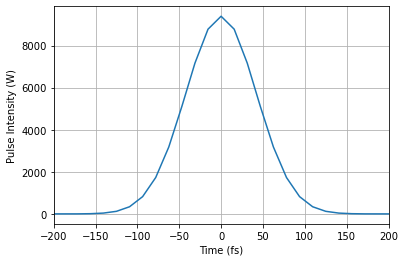

In [3]:
#Parameters
wl0 = 1e-6 #center wavelength
f0 = c/wl0
print('Center Wavelength = %0.3f um' %(wl0*1e6))
print('Center frequency = %0.3f THz' %(f0*1e-12))
 
pulse_energy = 1e-9
tau = 100e-15 #Pulse width

#Pulse creation
frep = 250e6
pulse = np.sqrt(0.939*pulse_energy/tau)*np.exp(-2*np.log(2)*(t/tau)**2)
pulse_energy = nlo.energy_td(t, pulse)

print('Pulse Energy = %0.3f nJ' %(pulse_energy*1e9))
print('Comb average power = %0.3f mW' %(pulse_energy*frep*1e3))

nlo.plot_magsq(t*1e15, pulse, xlim=[-200,200])

## Nonlinear element

In [4]:
Ws = 14e-3 #Beam waist of signal (mm)

#Crystal dispersion
alpha_a = 0.00691 #loss for signal in crystal (1/mm)
alpha_b = 0.00691 #loss for pump in crystal (1/mm)
# u = 112.778 #Group velocity mismatch (fs/mm)
u = 100
# b2a = -53.64 #second order GVD signal (fs^2/mm)
b2a =  -250/np.log(2)
b3a = 756.14 #third order GVD signal (fs^3/mm)
b4a = -2924.19 #fourth order GVD signal (fs^4/mm)
# b2b = 240.92 #second order GVD pump (fs^2/mm)
b2b =  250/np.log(2)
b3b = 211.285 #second order GVD pump (fs^3/mm)
b4b = -18.3758 #second order GVD pump (fs^4/mm)
deff = 2/pi*16e-9 #effective nonlinear coefficient (mm/V)
na = 2.2333# refractive index at signal
nb = 2.1935# refractive index at pump

#Dispersion functions (need to change units to base)
omega = 2*pi*f*1e-15
Da = alpha_a/2 - 1j*b2a*omega**2/2 - 1j*b3a*omega**3/6 - 1j*b4a*omega**4/24
Db = alpha_b/2 - 1j*u*omega - 1j*b2b*omega**2/2 - 1j*b3b*omega**3/6 - 1j*b4b*omega**4/24
Da = Da*1e3
Db = Db*1e3

#Nonlinear coupling
# nlc = np.sqrt(2*377)*deff*(omega+wl0)/(Ws*na*c*np.sqrt(pi*nb))
nlc = 0

Dispersion lengths:

In [5]:
Lda = (tau*1e15)**2/(4*np.log(2)*b2a)
Ldb = (tau*1e15)**2/(4*np.log(2)*b2b)
print(Lda)
print(Ldb)

-10.0
10.0


In [6]:
def nonlinear_operator(a, b, nlc):
        f = ifft(nlc*fft(b*np.conj(a)))
        g = -ifft(nlc*fft(a*a))
        return np.array([f,g])

In [7]:
def propagate(x, y):
    steps = int(L/h)
    x_evol = 1j*np.zeros([x.size, steps])
    y_evol = 1j*np.zeros([x.size, steps])
    
    for kz in range(steps):
        #Linear step
        x = ifft(Da*fft(x))
        y = ifft(Db*fft(y))

        #Nonlinear step
        #Runge-Kutta 4th order
        [k1, l1] = h*nonlinear_operator(x,y,nlc)
        [k2, l2] = h*nonlinear_operator(x+k1/2,y+l1/2,nlc)
        [k3, l3] = h*nonlinear_operator(x+k2/2,y+l2/2,nlc)
        [k4, l4] = h*nonlinear_operator(x+k3,y+l3,nlc)

        x = x + (1/6)*(k1+2*k2+2*k3+k4)
        y = y + (1/6)*(l1+2*l2+2*l3+l4)
        
        x_evol[:,kz] = x
        y_evol[:,kz] = y
        
    return x, y, x_evol, y_evol

## Simulation

In [8]:
#Length and step size
h = 1e-3/100
L = 10e-3
Da = np.exp(-h*Da)
Db = np.exp(-h*Db)

a, b, a_evol, b_evol = propagate(pulse, pulse)

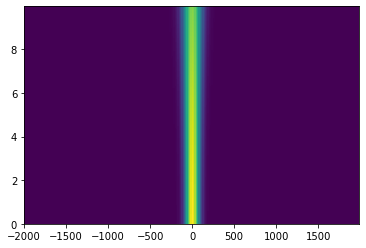

In [9]:
steps = np.size(a_evol, 1)
X,Y = np.meshgrid(t*1e15, np.arange(steps)*h*1e3)
plt.pcolormesh(X, Y, np.transpose(abs(a_evol)))

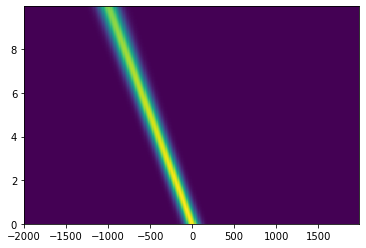

In [10]:
plt.pcolormesh(X, Y, np.transpose(abs(b_evol)))

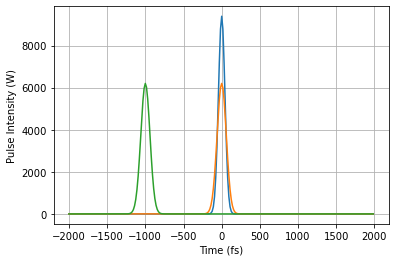

In [11]:
ax1 = nlo.plot_magsq(t*1e15,pulse)
ax1 = nlo.plot_magsq(t*1e15,a, ax=ax1)
ax1 = nlo.plot_magsq(t*1e15,b, ax=ax1)

FWHM = 141.682 fs


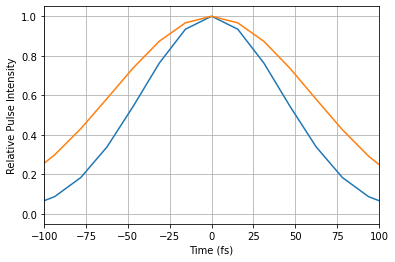

In [12]:
ax1 = nlo.plot_magsq_relative(t*1e15,pulse)
ax1 = nlo.plot_magsq_relative(t*1e15,a, ax=ax1)
ax1.set_xlim([-100,100])
print('FWHM = %0.3f fs' %(nlo.FWHM(t,a)*1e15))